In [7]:

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import os

for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))


In [8]:
import wfdb
import ast

def load_raw_data(df, sampling_rate, path):
    if sampling_rate == 100:
        data = [wfdb.rdsamp(path+f) for f in df.filename_lr]
    else:
        data = [wfdb.rdsamp(path+f) for f in df.filename_hr]
    data = np.array([signal for signal, meta in data])
    return data

path = '/Users/kyleharwick/Desktop/StreamLit/kaggle/ptb-xl-a-large-publicly-available-electrocardiography-dataset-1.0.1/'

sampling_rate=100

In [9]:
# load and convert annotation data
Y = pd.read_csv(path+'ptbxl_database.csv', index_col='ecg_id')
Y.scp_codes = Y.scp_codes.apply(lambda x: ast.literal_eval(x))


# Load raw signal data
X = load_raw_data(Y, sampling_rate, path)
#Ym = load_raw_data(Ym, sampling_rate, path)

# Load scp_statements.csv for diagnostic aggregation
agg_df = pd.read_csv(path+'scp_statements.csv', index_col=0)
agg_df = agg_df[agg_df.diagnostic == 1]


In [10]:
head = agg_df.head()
print(head)
print("Shape of merged df:", agg_df.shape)

                          description  diagnostic  form  rhythm  \
NDT    non-diagnostic T abnormalities         1.0   1.0     NaN   
NST_          non-specific ST changes         1.0   1.0     NaN   
DIG                  digitalis-effect         1.0   1.0     NaN   
LNGQT                long QT-interval         1.0   1.0     NaN   
NORM                       normal ECG         1.0   NaN     NaN   

      diagnostic_class diagnostic_subclass  \
NDT               STTC                STTC   
NST_              STTC                NST_   
DIG               STTC                STTC   
LNGQT             STTC                STTC   
NORM              NORM                NORM   

                                      Statement Category  \
NDT                    other ST-T descriptive statements   
NST_   Basic roots for coding ST-T changes and abnorm...   
DIG                    other ST-T descriptive statements   
LNGQT                  other ST-T descriptive statements   
NORM                

In [11]:
def aggregate_diagnostic(y_dic):
    tmp = []
    for key in y_dic.keys():
        if key in agg_df.index:
            tmp.append(agg_df.loc[key].diagnostic_class)
    return list(set(tmp))

In [12]:
# Apply diagnostic superclass
Y['diagnostic_superclass'] = Y.scp_codes.apply(aggregate_diagnostic)
head = Y.head()
print(head)
print("Shape of merged df:", Y.shape)

        patient_id   age  sex  height  weight  nurse  site     device  \
ecg_id                                                                  
1          15709.0  56.0    1     NaN    63.0    2.0   0.0  CS-12   E   
2          13243.0  19.0    0     NaN    70.0    2.0   0.0  CS-12   E   
3          20372.0  37.0    1     NaN    69.0    2.0   0.0  CS-12   E   
4          17014.0  24.0    0     NaN    82.0    2.0   0.0  CS-12   E   
5          17448.0  19.0    1     NaN    70.0    2.0   0.0  CS-12   E   

             recording_date                                  report  ...  \
ecg_id                                                               ...   
1       1984-11-09 09:17:34  sinusrhythmus periphere niederspannung  ...   
2       1984-11-14 12:55:37     sinusbradykardie sonst normales ekg  ...   
3       1984-11-15 12:49:10              sinusrhythmus normales ekg  ...   
4       1984-11-15 13:44:57              sinusrhythmus normales ekg  ...   
5       1984-11-17 10:43:15     

In [13]:
# Split data into train and test
test_fold = 10

# Define the lead_index you want to extract (e.g., lead_index = 1 for the second lead)
lead_index = 1

# Separate gendered datasets for the specified lead
male_X_train = X[(Y.strat_fold != test_fold) & (Y['sex'] == 0)][:, :, lead_index]
male_y_train = Y[(Y.strat_fold != test_fold) & (Y['sex'] == 0)].diagnostic_superclass
female_X_train = X[(Y.strat_fold != test_fold) & (Y['sex'] == 1)][:, :, lead_index]
female_y_train = Y[(Y.strat_fold != test_fold) & (Y['sex'] == 1)].diagnostic_superclass

male_X_test = X[(Y.strat_fold == test_fold) & (Y['sex'] == 0)][:, :, lead_index]
male_y_test = Y[(Y.strat_fold == test_fold) & (Y['sex'] == 0)].diagnostic_superclass
female_X_test = X[(Y.strat_fold == test_fold) & (Y['sex'] == 1)][:, :, lead_index]
female_y_test = Y[(Y.strat_fold == test_fold) & (Y['sex'] == 1)].diagnostic_superclass

# Aggregated datasets for the specified lead
X_train = X[(Y.strat_fold != test_fold)][:, :, lead_index]
y_train = Y[(Y.strat_fold != test_fold)].diagnostic_superclass
# Test
X_test = X[(Y.strat_fold == test_fold)][:, :, lead_index]
y_test = Y[Y.strat_fold == test_fold].diagnostic_superclass


In [14]:
print("Shape of X_test:", X_test.shape)
print("Shape of male X_test:", male_X_test.shape)


Shape of X_test: (2203, 1000)
Shape of male X_test: (1137, 1000)


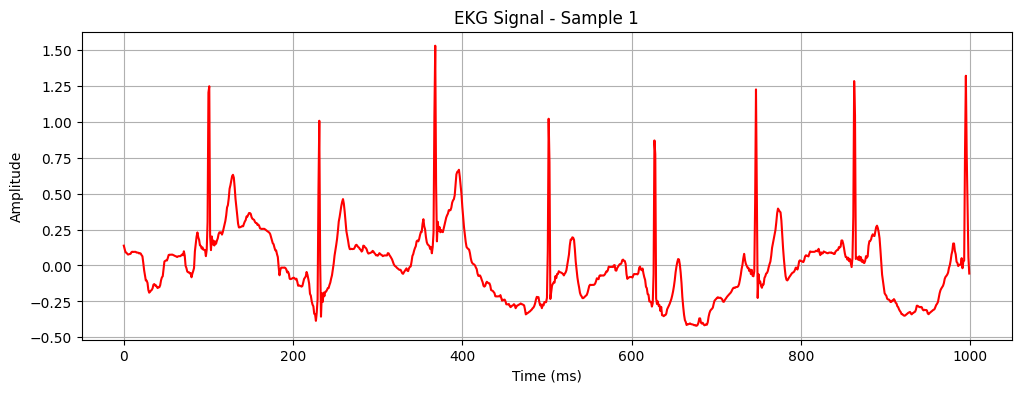

In [44]:
import matplotlib.pyplot as plt


sample_index = 1
        
# Extract the EKG signal for the selected sample and lead
ekg_signal = X_train[sample_index, :]

# Create a time axis (assuming a sampling rate of 100 Hz)
time_axis = range(len(ekg_signal))  # Assuming 100 Hz

# Plot the EKG signal
plt.figure(figsize=(12, 4))
plt.plot(time_axis, ekg_signal, color='red')
plt.title(f'EKG Signal - Sample {sample_index}')
plt.xlabel('Time (ms)')
plt.ylabel('Amplitude')
plt.grid(True)
plt.show()

In [123]:
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error
from sklearn.preprocessing import OneHotEncoder

from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, LSTM, Dropout, GRU, Bidirectional
from tensorflow.keras.optimizers import SGD
from tensorflow.random import set_seed

set_seed(455)
np.random.seed(455)

In [17]:
sc = MinMaxScaler(feature_range=(0, 1))
training_set = X_train.reshape(-1, 1)
training_set_scaled = sc.fit_transform(training_set)

In [18]:
X_train = X_train.reshape(X_train.shape[0], X_train.shape[1], 1)

In [19]:
n_steps = 1000  
features = 1  

model_lstm = Sequential()
model_lstm.add(LSTM(units=125, activation="tanh", input_shape=(n_steps, features)))
model_lstm.add(Dense(units=1))
model_lstm.compile(optimizer="RMSprop", loss="mse")

In [20]:
# Convert all labels to strings
y_train = [str(label) for label in y_train]

# Instantiate the encoder
encoder = OneHotEncoder(sparse=False)

# Reshape y_train if needed
y_train_reshaped = np.array(y_train).reshape(-1, 1)

# Fit and transform y_train using the encoder
y_train_encoded = encoder.fit_transform(y_train_reshaped)

/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/sklearn/preprocessing/_encoders.py:972: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
  warnings.warn(


In [21]:
encoder = OneHotEncoder(sparse=False)
y_train_reshaped = np.array(y_train).reshape(-1, 1)
y_train_encoded = encoder.fit_transform(y_train_reshaped)

/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/sklearn/preprocessing/_encoders.py:972: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
  warnings.warn(


In [22]:
X_train.shape


(19634, 1000, 1)

In [23]:
(n1, n2) = y_train_encoded.shape
print(n2)

26


In [24]:
# The LSTM architecture
model_lstm = Sequential()
model_lstm.add(LSTM(units=1, activation="tanh", input_shape=(n_steps, features)))
model_lstm.add(Dense(units=n2, activation = "softmax"))  # Or the appropriate number of units for your problem

# Compiling the model
model_lstm.compile(optimizer="RMSprop", loss="mse")

# Reshape X_train to match the input shape
X_train_reshaped = X_train.reshape(X_train.shape[0], n_steps, features)

# Now, you can fit the model with X_train_reshaped and y_train_encoded
model_lstm.fit(X_train_reshaped, y_train_encoded, epochs=10, batch_size=16)

Epoch 1/10
1228/1228 [==============================] - 105s 85ms/step - loss: 0.0329
Epoch 2/10
1228/1228 [==============================] - 104s 85ms/step - loss: 0.0303
Epoch 3/10
1228/1228 [==============================] - 104s 85ms/step - loss: 0.0303
Epoch 4/10
1228/1228 [==============================] - 105s 85ms/step - loss: 0.0303
Epoch 5/10
1228/1228 [==============================] - 105s 86ms/step - loss: 0.0303
Epoch 6/10
1228/1228 [==============================] - 104s 85ms/step - loss: 0.0303
Epoch 7/10
1228/1228 [==============================] - 104s 85ms/step - loss: 0.0303
Epoch 8/10
1228/1228 [==============================] - 104s 85ms/step - loss: 0.0303
Epoch 9/10
1228/1228 [==============================] - 104s 85ms/step - loss: 0.0303
Epoch 10/10
1228/1228 [==============================] - 105s 86ms/step - loss: 0.0303


In [64]:
#X_test = X_test.reshape(X_test.shape[0], X_test.shape[1], features)

predicted_ekg = model_lstm.predict(X_test)
predicted_ekg = sc.inverse_transform(predicted_ekg)

69/69 [==============================] - 1s 15ms/step


In [60]:
predicted_ekg

array([[0.0051545 , 0.00251869, 0.00187007, ..., 0.40838334, 0.11188487,
        0.01789595],
       [0.00510339, 0.00248965, 0.00184392, ..., 0.41025624, 0.11175952,
        0.01778877],
       [0.00510417, 0.00249009, 0.00184431, ..., 0.4102276 , 0.11176146,
        0.01779041],
       ...,
       [0.00512938, 0.00250441, 0.0018572 , ..., 0.40930203, 0.11182366,
        0.01784334],
       [0.00510399, 0.00248999, 0.00184422, ..., 0.4102341 , 0.111761  ,
        0.01779004],
       [0.00508141, 0.00247718, 0.0018327 , ..., 0.41106656, 0.11170465,
        0.0177425 ]], dtype=float32)

In [65]:
valid_indices = y_test.index
print(valid_indices)

#Y[9, :]
sample_index = 9
        
# Extract the EKG signal for the selected sample and lead
ekg_signal_2 = X_test[sample_index, :]

Index([    9,    38,    40,    57,    59,    63,    65,    75,    76,    79,
       ...
       21622, 21673, 21675, 21764, 21796, 21809, 21812, 21818, 21819, 21826],
      dtype='int64', name='ecg_id', length=2203)


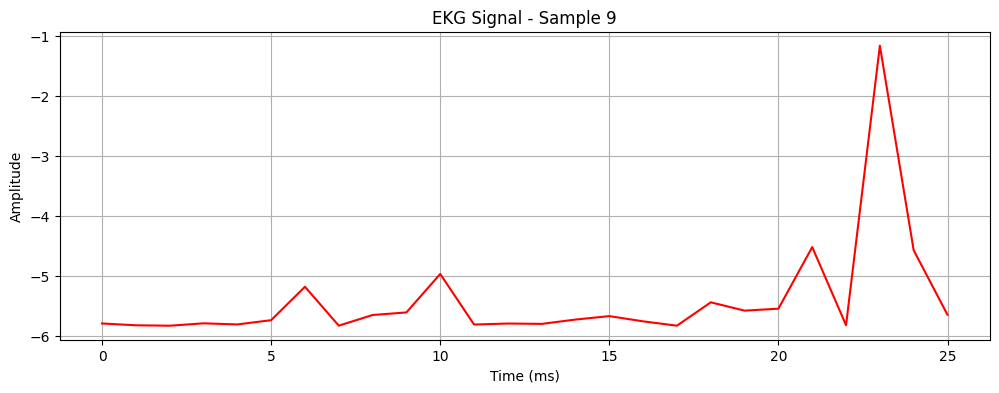

In [66]:
#sample_index = 9
# Extract the EKG signal for the selected sample and lead
ekg_signal = predicted_ekg[sample_index, :]
# Assuming sample_index is the index of the row you want to access
#ekg_signal_2 = y_test.loc[sample_index, :]

# Create a time axis (assuming a sampling rate of 100 Hz)
time_axis = range(len(ekg_signal))  # Assuming 100 Hz
real_time_axis = range(len(ekg_signal_2))  # Assuming 100 Hz


# Plot the EKG signal
plt.figure(figsize=(12, 4))
#plt.plot(real_time_axis, ekg_signal_2, color="gray")
plt.plot(time_axis, ekg_signal, color='red')
plt.title(f'EKG Signal - Sample {sample_index}')
plt.xlabel('Time (ms)')
plt.ylabel('Amplitude')
plt.grid(True)
plt.show()